In [9]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 7, 
                                   'axes.titlesize': 9,
                                   'axes.labelsize': 8,
                                   'xtick.labelsize': 7,
                                   'ytick.labelsize': 7,
                                   'legend.fontsize' : 7,
                                   'legend.markerscale': 0.7,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 3.5,
                                   'ytick.major.size': 3.5,
                                   'xtick.minor.size': 2.5,
                                   'ytick.minor.size': 2.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Figure 1 - Dimensionality vs. encoding performance

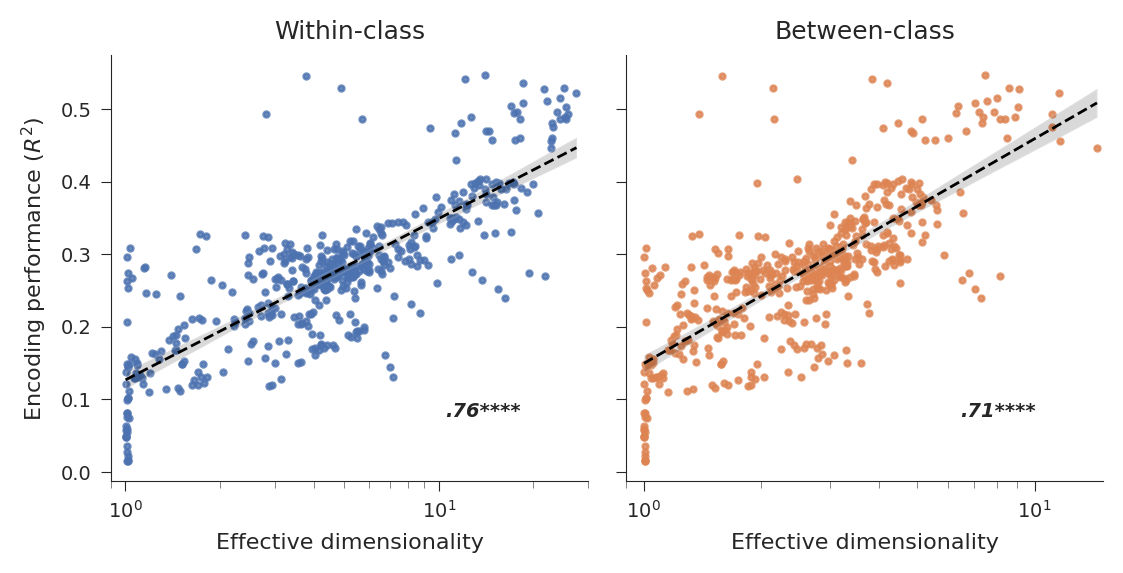

In [10]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.75))

axs[0].set_xlim(0.9, 30)
sns.regplot(data=data, x='within-concept dimensionality (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[0])
axs[0].set(title='Within-class', xlabel='Effective dimensionality', ylabel=r'Encoding performance ($R^2$)', xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.7, 0.15), ax=axs[0])

axs[1].set_xlim(0.9, 15)
sns.regplot(data=data, x='between-concept dimensionality', y='score', 
            logx=True, color=sns.color_palette()[1],
            scatter_kws={'alpha': 0.8, 's': 4}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[1])
axs[1].set(title='Between-class', xlabel='Effective dimensionality', ylabel=None, yticklabels=[], xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.7, 0.15), ax=axs[1])

plt.savefig('saved/results_01_ED.png', dpi=300)
plt.show()

---
# Figure 2 - Dimensionality vs. layer depth

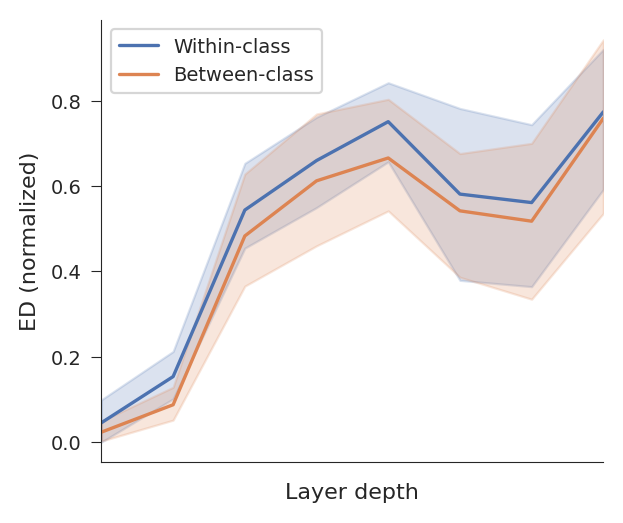

In [11]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.kind != 'Untrained') & (data.architecture == 'ResNet18')]

normed_metrics = data.groupby(['architecture', 'task', 'kind', 'source'])\
                     .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
normed_metrics = normed_metrics[['between-concept dimensionality', 'within-concept dimensionality (mean)']]
normed_metrics.columns = [c + ' normed' for c in normed_metrics.columns]
data = pd.concat([data, normed_metrics], axis=1)

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean) normed', 'between-concept dimensionality normed'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(3, 2.5))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED (normalized)', xticklabels=[], xlim=(0, 7))
ax.tick_params(axis='x', length=0)

ax.legend(loc='upper left', labels=['Within-class', 'Between-class'])

plt.savefig('saved/results_02_depth.png', dpi=300)
plt.show()

---
# Figure 3 - Dimensionality vs. encoding performance by layer

In [12]:
# dataset = 'imagenet'
# data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
#                 pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
#                 on=id_columns)
# data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

# def corr_layer(x):
#     r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
#     r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
#     return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

# by_layer = data.groupby(['architecture', 'layer'])['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']
# by_layer = by_layer.apply(corr_layer).reset_index()
# by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
# data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

# fig, axs = plt.subplots(1, 2, figsize=(5.5, 2))

# sns.lineplot(data=data[data.architecture == 'ResNet18'], x='layer', y='r_score_dim', hue='dim_type', ax=axs[0])
# sns.scatterplot(data=data[(data.architecture == 'ResNet18')], 
#                 x='layer', y='r_score_dim', hue='dim_type', style='significant', 
#                 style_order=[True, False], markers=['o', 'v'], alpha=0.5, ax=axs[0])
# axs[0].set(title='ResNet18', xlabel=None, ylabel='ED-Encoding correlation', xticklabels=[], xlim=(-0.2, 7.2), ylim=(0, 1))

# sns.lineplot(data=data[data.architecture == 'ResNet50'], x='layer', y='r_score_dim', hue='dim_type', ax=axs[1])
# sns.scatterplot(data=data[(data.architecture == 'ResNet50')], 
#                 x='layer', y='r_score_dim', hue='dim_type', style='significant', 
#                 style_order=[True, False], markers=['o', 'v'], alpha=0.5, ax=axs[1])
# axs[1].set(title='ResNet50', xlabel='Layer depth', ylabel='ED-Encoding correlation', xticklabels=[], xlim=(-0.4, 15.4), ylim=(0, 1))

# axs[0].legend().remove()
# handles, _ = axs[1].get_legend_handles_labels()
# axs[1].legend(loc='lower right', 
#               labels=['Within-class', 'Between-class', r'$p < 0.05$', r'$ns$'], 
#               handles=handles[:2] + handles[-2:])

# plt.savefig('saved/results_03_layerwise_old.png', dpi=300)
# plt.show()

/home/eric/anaconda3/envs/bs/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


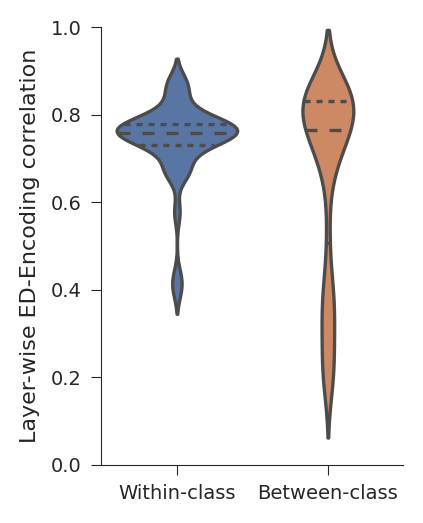

In [13]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(2, 2.5))

sns.violinplot(data=data, y='r_score_dim', x='dim_type', inner='quartile', ax=ax)
ax.set(xlabel=None, ylabel='Layer-wise ED-Encoding correlation', 
       xticklabels=['Within-class', 'Between-class'], ylim=(0, 1))

plt.savefig('saved/results_03_layerwise.png', dpi=300)
plt.show()

---
# Figure 4 - Dimensionality vs. layer depth

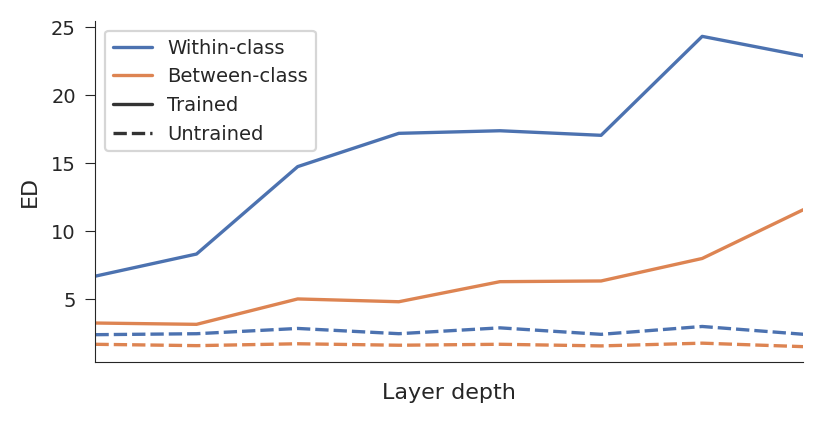

In [14]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.source == 'PyTorch') & (data.architecture == 'ResNet18')]

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(4, 2))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', style='kind',
             style_order=['Supervised', 'Untrained'],
             ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED', xticklabels=[], xlim=(0, 7))
ax.tick_params(axis='x', length=0)

handles, _ = ax.get_legend_handles_labels()
ax.legend(loc='upper left', 
          labels=['Within-class', 'Between-class', 'Trained', 'Untrained'], 
          handles=handles[1:3] + handles[4:6])

plt.savefig('saved/results_04_training.png', dpi=300)
plt.show()

---
# Figure 5 - Classification

/home/eric/anaconda3/envs/bs/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


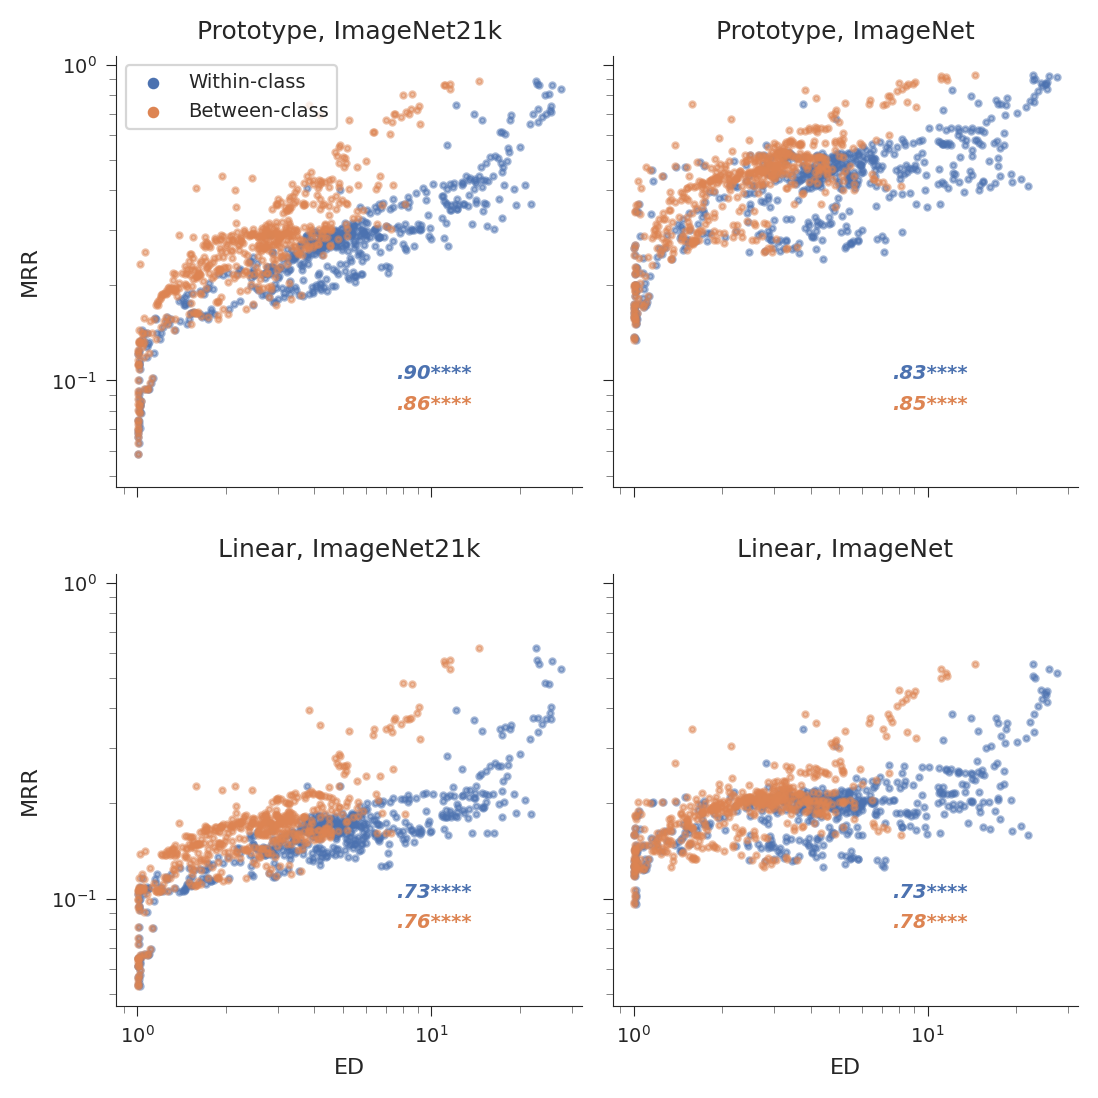

In [15]:
data = pd.DataFrame()
for d, c in [('imagenet', 'linear'), ('imagenet', 'prototype'), 
             ('imagenet21k', 'linear'), ('imagenet21k', 'prototype')]:
    data_i = pd.read_csv(f'../../results/n-shot|dataset:{d}|classifier:{c}|pooling:True.csv')
    data_i = data_i[data_i.n_train == 50]
    data_i = data_i.drop([c for c in data_i.columns if c not in id_columns + ['MRR']], axis='columns')
    data_i = data_i.groupby(id_columns, as_index=False).mean()
    data_i = data_i.assign(classifier=c, dataset_nshot=d)
    data = data.append(data_i)
del data_i

dataset = 'imagenet'
data = pd.merge(data, 
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data.melt(id_vars=id_columns + ['MRR', 'classifier', 'dataset_nshot'], 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

g = sns.lmplot(data=data, x='metric_value', y='MRR', hue='metric', col='classifier', row='dataset_nshot',
               col_order=['prototype', 'linear'], row_order=['imagenet21k', 'imagenet'],
               scatter_kws={'alpha': 0.5, 's': 4}, sharex=True, sharey=True, 
               height=2.75, fit_reg=False, legend=False)

for ax in g.axes.flatten():
    ax.set(xscale='log', yscale='log')
for row, c in zip(range(g.axes.shape[0]), ['Prototype', 'Linear']):
    for col, d in zip(range(g.axes.shape[1]), ['ImageNet21k', 'ImageNet']):
        g.axes[row, col].set(title=f'{c}, {d}', xlabel='ED' if row == 1 else None)
        annotate_corr(data[(data.classifier == c.lower()) & 
                           (data.dataset_nshot == d.lower()) & 
                           (data.metric == 'within-concept dimensionality (mean)')], 
                      x='metric_value', y='MRR', 
                      ax=g.axes[row, col], 
                      pos=(0.6, 0.25), color=sns.color_palette()[0])
        annotate_corr(data[(data.classifier == c.lower()) & 
                           (data.dataset_nshot == d.lower()) & 
                           (data.metric == 'between-concept dimensionality')], 
                      x='metric_value', y='MRR', 
                      ax=g.axes[row, col], 
                      pos=(0.6, 0.18), color=sns.color_palette()[1])

legend = g.axes[0, 0].legend(loc='upper left',
                             labels=['Within-class', 'Between-class'], 
                             scatterpoints=1)
legend.legendHandles[0].set_sizes([10])
legend.legendHandles[1].set_sizes([10])
legend.legendHandles[0].set_alpha(1)
legend.legendHandles[1].set_alpha(1)

g.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig('saved/results_05_classification.png', dpi=300)
plt.show()

---
# Figure 6 - Counter-example

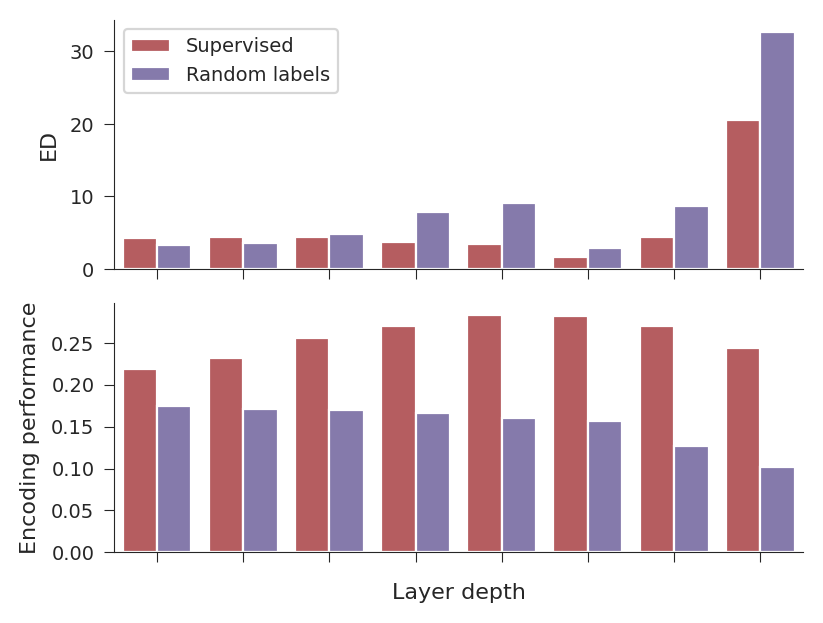

In [16]:
data = pd.merge(pd.read_csv(f'../../results/counter-example|encoding.csv'),
                pd.read_csv(f'../../results/counter-example|eigmetrics.csv'), 
                on=['architecture', 'task', 'kind', 'source', 'layer'])

fig, axs = plt.subplots(2, 1, figsize=(4, 3))

sns.barplot(data=data, x='layer', y='effective dimensionality', hue='kind', ax=axs[0], 
            palette=sns.color_palette()[3:5])
axs[0].set(xlabel=None, ylabel='ED', xticklabels=[])
sns.barplot(data=data, x='layer', y='score', hue='kind', ax=axs[1], 
            palette=sns.color_palette()[3:5])
axs[1].set(xlabel='Layer depth', ylabel='Encoding performance', xticklabels=[])

handles, _ = axs[0].get_legend_handles_labels()
axs[0].legend(labels=['Supervised', 'Random labels'], handles=handles)
axs[1].legend().remove()

plt.savefig('saved/results_06_counter-example.png', dpi=300)
plt.show()